# Kinetic Sunyaev-Zeldovich Angular Power Spectrum

### Author:  Jesse Randall
### Advisor: Dr. James Cooney
### Date:    27/01/2022

## Changelog

### Edits prior to return in Jan. 2022

### Edits after Return in Jan. 2022

#### 25/01/2022: Refactored code into current Jupyter Notebook

#### 12/02/2022: Making GitHub Repository

## Preface

### Introduction:

### Technical Details:

### Index

## Section 0: Import packages and define global constants

In [1]:
##### PACKAGES #####
import numpy as np                     # Standard shorthand for NumPy package.
import scipy.integrate as spint        # My shorthand for scipy.integrate module.
import scipy.misc      as spmisc       # My shorthand for scipy.misc module.
import matplotlib.pyplot as plt        # Standard shorthand for matplotlib package.
plt.rcParams.update({'font.size':16})  # Change font size on plots for easy reading.

##### GLOBAL CONSTANTS #####

##### General #####
NL          = '\n' # New line for print statements.

##### Plots #####
j           = 0    # Figure index. Increment when plotting to designate next figure.
FIGX        = 10   # Figure x dimension.
FIGY        = 8    # Figure y dimension.
POINTS      = int(1e3) # Number of points to plot.

# 1 True, 0 False.
# To plot something, change the 0 to a 1 for the plot you wish to make.
PLOTDLPS    = 1    # Plot dimensionless linear power spectrum of density fluctuations.
PLOTVARINT  = 1    # Plot integrand of variance of density fluctuations.
PLOTSD      = 1    # Plot standard deviation of density fluctuations.
PLOTBIAS    = 1    # Plot bias parameter.
PLOTSTDNDM  = 0    # Plot Sheth-Tormen mass function.
PLOTPSINT   = 0    # Plot integrand of contributions to non-linear power spectrum.
PLOTPS      = 0    # Plot non-linear power spectrum.

##### Variables for DLPS #####
n       =  1     # Power of Power Law.
a       =  1     # Scale Factor.
DHP     =  0.710 # Dimensionless Hubble Parameter.
H0      = 71.0   # (km/s/Mpc) Hubble constant. 
OMEGAM0 =  0.30  # Mass Density Parameter evaluated now.
OMEGAL0 =  0.70  # Cosmological Density Parameter evaluated now.
OMEGAB0 =  0.05  # Baryon Density Parameter evaluated now.
C       =  2.99792458e5   # (km/s) Speed of light. 
NORM    = (2 * np.pi)**3  # Normalization factor for dimensionless power spectrum
# Shape Parameter characterizes the dependence on cosmological parameters.
GAMMA   = OMEGAM0*DHP / (np.exp(OMEGAB0*(1 + 1.3/OMEGAM0)))
kLIN    = np.logspace(-2, 2, POINTS)  # (1/Mpc) Wavenumber  
# Numerical Parameters from simulations
ai      = np.array((2.34 , 3.89, 16.1 , 5.46, 6.71))
bi      = np.array((0.785, 0.05,  0.95, 0.169))    

##### Variables for SD #####
MSOLAR = 1.989e30 # (kg) Mass of Sun
M_MAG  = np.logspace(12,21,POINTS) # (M/M_0) Array for range of mass for plotting in solar masses.
M_SOL  = M_MAG.copy()*MSOLAR       # (kg) Array for range of mass in kg for calculation.
RHO0   = 2.7e-27  # (kg/m**3) Density of universe. Ryden pg 11.
P1     = 3 / (4 * np.pi * RHO0) # constant in Top Hat Window function.
P2     = 4*np.pi  # constant in integrand.
KCONV  = DHP / (3.086e22) # conversion of k from h/Mpc to 1/m.
kVAR   = np.logspace(-6,2,POINTS) # (1/Mpc) Wavenumber
KMIN   = 0        # Minimum value of k to integrate from.
KMAX   = np.inf   # Maximum value of k to integrate to.
INTLIM = 500      # Upper bound on the number of subintervals used for spint.quad.

##### Variables for Bias Param #####
DELC = 1.68

##### Variables for Nonlinear Power Spectrum #####
MCO   =  MSOLAR*10**14 # Mass cutoff
# Intermediate calculation for the scale radius
SRCON = (3 / (800*np.pi*RHO0))**(1/3)    
DX    = np.sqrt(2.2e-16)           

# Parameters for Sheth-Tormen mass function.
ALPHA = 0.707
Q     = 0.3
A     = 0.322 

## Section 1: Dimensionless Linear Power Spectrum

### Section 1.0: Notes on DLPS

### Section 1.1: Defined funcitons for DLPS

In [2]:
def MDP(af):
    '''
    calculate mass density parameter at given scale factor a.
    '''
    return OMEGAM0 / (OMEGAM0 + af**3 * OMEGAL0)

def cDP(af):
    '''
    calculate cosmological density parameter at given scale factor a.
    '''
    return 1 - MDP(af)

def g(af):
    '''
    calculate g, Relative Growth Factor, at given scale factor a.
    '''
    return 2.5 * MDP(af) / (MDP(af)**(4/7) - cDP(af) + (1 + MDP(af)/2) * \
           (1 + cDP(af) / 70))

def D(af):
    '''
    calcualte D, Linear Growth Factor, at given scale factor a. D_0 is the LGF. 
    (evaluated now at af=1)
    '''
    return af * g(af)

def q(kf):
    '''
    calculate q, Shape Parameter, for given range of wavenumbers k.
    '''
    return kf / (GAMMA * DHP)

def delH(nf):
    '''
    Not sure what this is called.
    '''
    return (1.94 * 10**(-5)) * OMEGAM0**(-bi[0] - bi[1] * np.log(OMEGAM0)) \
           * np.exp(-bi[2] * (nf - 1) - bi[3] * (nf - 1)**2)

def Af(nf):
    '''
    Not sure what this is called. Have a note in my copy of dissertation saying 
    it is the Normalization Factor.
    '''
    return delH(nf)**2 * ((C / H0)**(nf + 3)) / (4 * np.pi)

def LPS(kf, af, nf):
    '''
    Follows formulation given in equation 5.1 on page 42.
    Function for Linear Power Spectrum P(k, a) = P(k).
    (evaluated now at af=1)
    '''
    return Af(nf) * (kf**nf) * ((D(af) / D(1))**2) * (np.log(1 + ai[0] * q(kf)) \
           / (ai[0] * q(kf)))**2 / (1 + (ai[1] * q(kf)) +  ((ai[2] * q(kf))**2) \
           + ((ai[3] * q(kf))**3) + ((ai[4] * q(kf))**4))**0.5

### Section 1.2: Plot DLPS

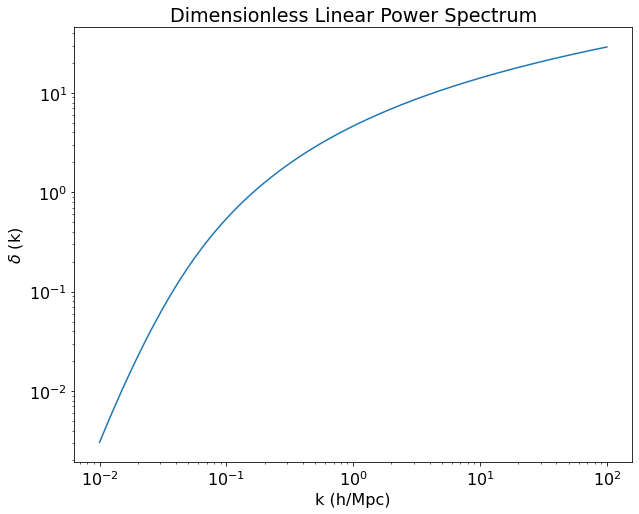

In [3]:
if PLOTDLPS == 1:   
    '''
    This function differs from what is listed in Dr. Cooney's dissertation by 
    the NORM factor.
    '''
    # Dimensionless LPS
    graphLPS = NORM * (kLIN**3) * LPS(kLIN, a, n) / (2 * np.pi**2)
    
    # Figure parameters
    j+=1
    plt.figure(j, figsize=(FIGX,FIGY))
    plt.loglog(kLIN, graphLPS, '-')
    plt.title('Dimensionless Linear Power Spectrum')
    plt.xlabel('k (h/Mpc)')
    plt.ylabel(r'$\delta$ (k)')
    plt.savefig('DLPS.pdf')

## Section 2: Variance/Standard Deviation of density contrast

### Section 2.0: Notes on Variance/Standard Deviation of Density Contrast

### Section 2.1: Define functions for variance integrand

In [4]:
def FTTHWF(kf, M):
    '''
    Fourier transform of top hat window function.
    '''
    return 3*(np.sin(kf * np.cbrt(M * P1)) - (kf * np.cbrt(M * P1)) \
              * np.cos(kf * np.cbrt(M * P1))) / (kf * np.cbrt(M * P1))**3

def VARIntegrand(kf, M):
    '''
    Integrand for variance of density contrast.
    '''
    return P2 * kf**2 * LPS(kf,a,n) * FTTHWF(KCONV*kf,M)**2

### Section 2.2: Plot integrand for range of mass

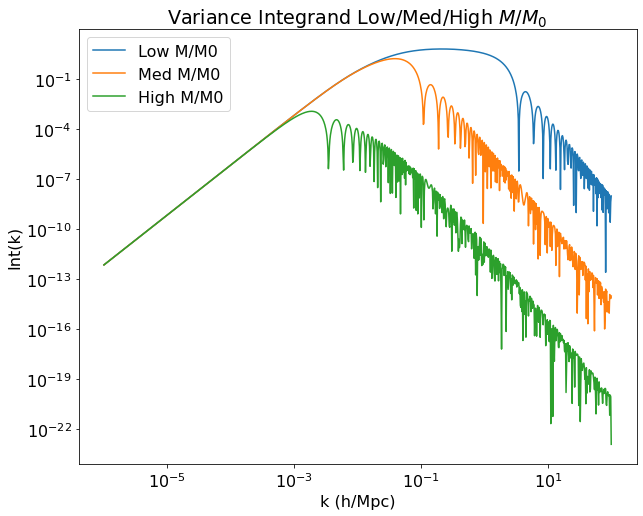

In [5]:
# Plot integrand for values of M to get an idea of when it behaves weirdly when 
# varying k to determine a proper interval for integration.

if PLOTVARINT == 1: 
    graphINTlow  = VARIntegrand(kVAR, M_SOL[0])
    graphINTmed  = VARIntegrand(kVAR, M_SOL[POINTS // 2])
    graphINThigh = VARIntegrand(kVAR, M_SOL[-1])

    j+=1
    plt.figure(j, figsize=(FIGX,FIGY))
    plt.loglog(kVAR, graphINTlow,  label='Low M/M0')
    plt.loglog(kVAR, graphINTmed,  label='Med M/M0')
    plt.loglog(kVAR, graphINThigh, label='High M/M0')
    plt.legend()
    plt.title(r'Variance Integrand Low/Med/High $M/M_0$')
    plt.xlabel('k (h/Mpc)')
    plt.ylabel(r'Int(k)')
    plt.savefig('VARIntALL.pdf')

### Section 2.3: Define function to evaluate the numerical integral for Standard Deviation

In [6]:
def SDInt(M):
    '''
    Numerical integration for variance of density contrast. Returns individual
    points for plot of STD.
    
    I have to use the property called broadcasting for np.array to avoid using
    loops at all. Otherwise the code is not efficient. I came across a method
    in NumPy that vectorizes a function and believe that is what I need to do
    to use broadcasting for this numerical integral.
    '''
    return np.sqrt(spint.quad(VARIntegrand, a=KMIN, b=KMAX, args=(M), limit=INTLIM)[0])

#### Notes on Section 2.3 for funciton SDInt

In [7]:
# This gives just the output of the numerical integal for the plotted integrand of variance 
# in the previous section. I am using this to show the impact of the estimated error that
# scipy.integrate.quad() provides.

lowTest  = spint.quad(VARIntegrand, a=KMIN, b=KMAX, args=(M_SOL[0]), limit=INTLIM)
medTest  = spint.quad(VARIntegrand, a=KMIN, b=KMAX, args=(M_SOL[POINTS//2]), limit=INTLIM)
highTest = spint.quad(VARIntegrand, a=KMIN, b=KMAX, args=(M_SOL[-1]), limit=INTLIM)

percentErrorLow  = 100 *  lowTest[1] /  lowTest[0]
percentErrorMed  = 100 *  medTest[1] /  medTest[0]
percentErrorHigh = 100 * highTest[1] / highTest[0]

print('Value of numerical integral of variance for low values of M/M0: ' , NL , lowTest[0] , NL , 
      'Value of estimated error for numerical integral of variance for low values of M/M0: ' , NL , lowTest[1] , NL , 
      
      'Looks pretty good considering the value of the integral is 9 orders of magnitude above the error.' , NL , sep='')

print('Value of numerical integral of variance for medium values of M/M0: ' , NL  , medTest[0] , NL , 
      'Value of estimated error for numerical integral of variance for med values of M/M0: ' , NL  , medTest[1] , NL , 
      'Percent error: ' , percentErrorMed , NL , 
      'The value of the integral is approaching the value of the error but is still not too bad.' , NL , sep='')

print('Value of numerical integral of variance for high values of M/M0: ' , NL  , highTest[0] , NL , 
      'Value of estimated error for numerical integral of variance for high values of M/M0: ' , NL  , highTest[1] , NL , 
      'Percent error: ' , percentErrorHigh , NL , 
      'The relative error is on the order of a percent now. \n' , 
      'May need to look for another integration method. Will discuss with Dr. Cooney.' , sep='')

Value of numerical integral of variance for low values of M/M0: 
6.981446830886096
Value of estimated error for numerical integral of variance for low values of M/M0: 
8.547991923594269e-08
Looks pretty good considering the value of the integral is 9 orders of magnitude above the error.

Value of numerical integral of variance for medium values of M/M0: 
0.08300956614233516
Value of estimated error for numerical integral of variance for med values of M/M0: 
1.4565609521358612e-08
Percent error: 1.7546904770449223e-05
The value of the integral is approaching the value of the error but is still not too bad.

Value of numerical integral of variance for high values of M/M0: 
2.9057343953241298e-06
Value of estimated error for numerical integral of variance for high values of M/M0: 
1.3017024651569294e-08
Percent error: 0.44797709909467714
The relative error is on the order of a percent now. 
May need to look for another integration method. Will discuss with Dr. Cooney.


### Section 2.4: Plot Standard Deviation

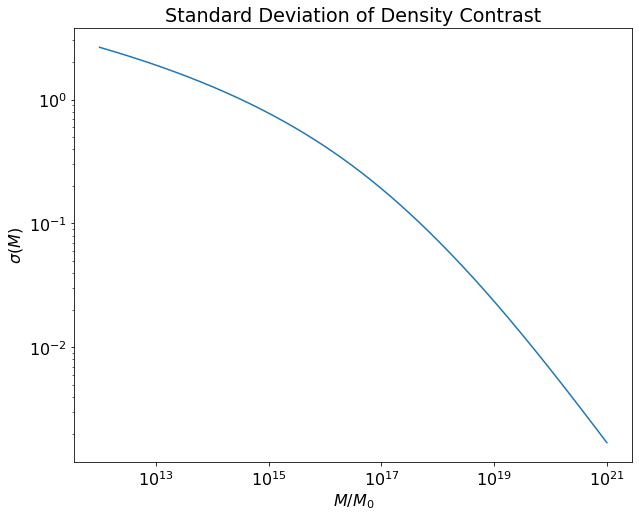

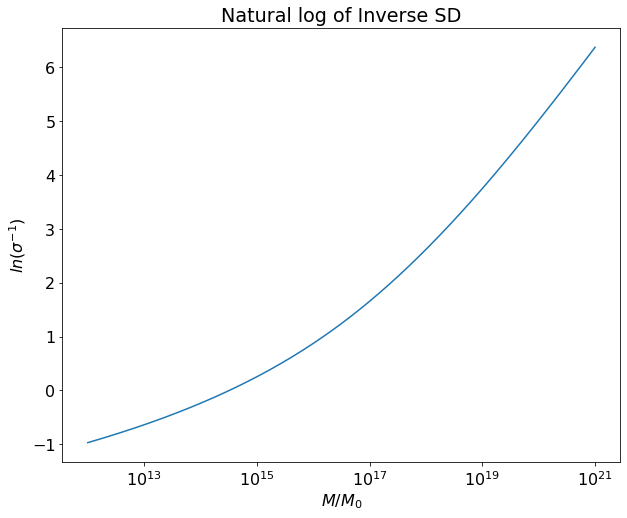

In [8]:
if PLOTSD == 1:

    # Initialize NumPy array for SD points to plot.
    graphSD = np.zeros(POINTS)
    
    # Numerically integrate the standard deviation and store values in "graphSD".
    for i in range(POINTS):
        graphSD[i] = SDInt(M_SOL[i])
    
    # Plot for Standard Deviation of Density Contrast
    j+=1
    plt.figure(j,figsize=(FIGX,FIGY))
    plt.loglog(M_MAG, graphSD)
    plt.title('Standard Deviation of Density Contrast')
    plt.xlabel(r'$M/M_0$')
    plt.ylabel(r'$\sigma(M)$')
    plt.savefig('SD.pdf')
    
    # Plot for Natural log of inverse SD. Needed later on in Sheth-Tormen mass function.
    j+=1
    plt.figure(j,figsize=(FIGX,FIGY))
    plt.semilogx(M_MAG, np.log(graphSD**(-1)))
    plt.title('Natural log of Inverse SD')
    plt.xlabel(r'$M/M_0$')
    plt.ylabel(r'$ln(\sigma^{-1})$')
    plt.savefig('lnSDInv.pdf')

## Section 3: Bias factor b(M) for 2H term of Nonlinear Power Spectrum

### Section 3.0: Notes on bias factor for 2 halo term of Nonlinear Power Spectrum

### Section 3.1: Define functions for bias factor

In [9]:
def nu(M):
    '''
    Peak height in Jing (1998)
    '''
    if PLOTSD == 0:
        # Haven't done the numerical integration yet. Have to do now.
        SD = np.zeros(POINTS)
        for i in range(POINTS):
            SD[i] = SDInt(M_SOL[i])
        return DELC / SD
    else:
        # Have done the numerical integration so do not need to do it again.
        return DELC / graphSD

def bParam(M):
    '''
    Bias parameter used in the power spectrum of the 2-point correlation function.
    '''
    return (1 + (nu(M)**2 - 1)/DELC) * (1/(2*nu(M)**4) + 1)**(0.06-0.02*n)

### Section 3.2: Plot bias factor

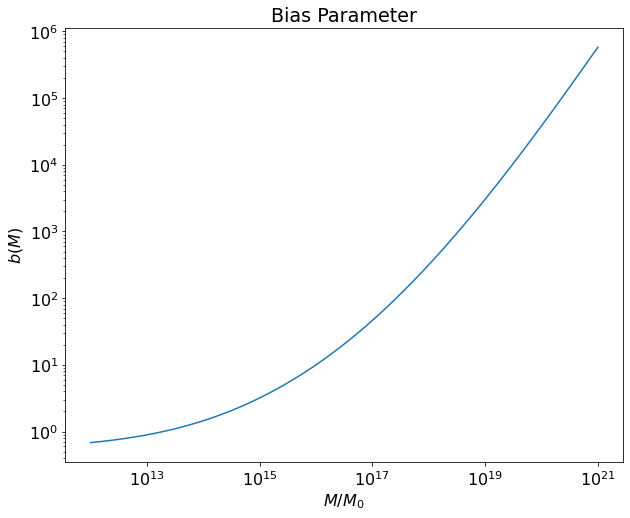

In [10]:
if PLOTBIAS == 1:
    
    graphBIAS = bParam(M_SOL)
    
    j+=1
    plt.figure(j,figsize=(FIGX,FIGY))
    plt.loglog(M_MAG, graphBIAS)
    plt.title('Bias Parameter')
    plt.xlabel(r'$M/M_0$')
    plt.ylabel(r'$b(M)$')
    plt.savefig('BIAS.pdf')

## Section 4: Nonlinear Power Spectrum

### Section 4.1: Define functions for integrand of NLPS

In [11]:
def CP(M):
    '''
    Expression for the concentration parameter found in Jing and Suto.
    '''
    if M < MCO:
        return 5*SDInt(M)
    else:
        return 9*SDInt(M)
    
def SR(M, cp):
    '''
    Scale radius.
    '''
    return SRCON*M**(1/3) / cp

def delta(M, cp):
    '''
    Characteristic density.
    '''
    if M < MCO:
        # Density amplitude for NFW density profile
        return 200*cp**(3) / (3*(np.log(1 + cp) - cp/(1+cp))) 
    else:
        # Density amplitude for Moore density profile
        return 100*cp**(3) / np.log(1 + cp**(3/2)) 

def UP(q,M):
    '''
    Mixed density profile depending on value of M. MCO is the cutoff for 
    switching from one profile to the other.
    '''
    if M < MCO:
        '''
        Algebraic expression from Ma and Fry (2000) for fourier transform of NFW 
        density profile. 4% rms error
        '''
        return 4*np.pi*(np.log(np.exp(1)+1/q) - np.log(np.log(np.exp(1)\
                    +1/q)/3)) / ((1+q)**(1.1))**(2/1.1)
    else:
        '''
        Algebraic expression from Ma and Fry (2000) for fourier transform of Moore 
        density profile. 1% rms error
        '''
        return 4*np.pi*(np.log(np.exp(1) + 1/q) + 0.25*np.log(np.log(np.exp(1)\
                    + 1/q))) / (1 + 0.8*q**(1.5))
    
def lnInvSD(M):
    '''
    Intermediate caluculation in mass functions.
    '''
    return np.log(SDInt(M)**(-1))

def PSdndm(M):
    '''
    Press-Schecter mass/distribution function.
    '''
    dlnInvSD = spmisc.derivative(lnInvSD,M,dx=M*DX,order=3)
    Nu       = nu(M)
    return np.sqrt(2/np.pi) * dlnInvSD * RHO0 * Nu * np.exp(-Nu**(2)/2) / M

def STdndm(M):
    '''
    Sheth-Tormen mass/distribution function.
    '''
    # Third order central finite difference method for estimating derivative
    # dlnInvSD = (lnInvSD(np.exp(np.log(M)+DX)) - lnInvSD(np.exp(np.log(M)-DX))) / 2*DX
    dlnInvSD = spmisc.derivative(lnInvSD,M,dx=DX,order=3)
    NuP      = ALPHA**(-1/2)*nu(M)
    return (RHO0/M**2) * dlnInvSD * 2*A * (1 + 1/(NuP)**(2*Q)) * np.sqrt(NuP**(2)\
            / 2*np.pi) * np.exp(-NuP**(2)/2)
    
def PS1HInteg(M,kf):
    '''
    Integrand of 1 halo power spectrum contribution.
    '''
    cp = CP(M)
    sr = SR(M, cp)
    return STdndm(M) * (sr**(3) * delta(M, cp) * UP(KCONV*kf*sr,M))**2

def PS2HInteg(M,kf):
    '''
    Integrand of 1 halo power spectrum contribution.
    '''
    cp = CP(M)
    sr = SR(M, cp)
    return STdndm(M) * sr**3 * delta(M,cp) * UP(KCONV*kf*sr,M) * bParam(M)

### Section 4.2: Plot NLPS Integrand

In [12]:
if PLOTSTDNDM == 1:
    # Sheth-Tormen
    
    if PLOTSD == 0:
        graphSTDNDM = np.zeros(POINTS)
        for i in range(POINTS):
            graphSTDNDM[i] = STdndm(M_SOL[i])
    else:
        graphSTDDNDM = STdndm(M_SOL)
    
        
    j+=1
    plt.figure(j, figsize=(FIGX,FIGY))
    plt.semilogx(M_MAG, graphSTDNDM)
    plt.title(r'Sheth-Tormen Mass Function')
    plt.xlabel(r'$M/M_0$')
    plt.ylabel(r'dn/dm')
    plt.savefig('STDNDM.pdf')
    
if PLOTPSINT == 1:
    '''
    Broadcasting of Numpy arrays is not magic so don't treat it like it is.
    '''
    PS1HINT = np.zeros((3,POINTS))
    PS2HINT = np.zeros((3,POINTS))
    
    for i in range(POINTS):
        PS1HINT[0,i] = PS1HInteg(M_SOL[i], kLIN[0])
        PS1HINT[1,i] = PS1HInteg(M_SOL[i], kLIN[POINTS // 2])
        PS1HINT[2,i] = PS1HInteg(M_SOL[i], kLIN[POINTS - 1] )

        PS2HINT[0,i] = PS2HInteg(M_SOL[i], kLIN[0])
        PS2HINT[1,i] = PS2HInteg(M_SOL[i], kLIN[POINTS // 2])
        PS2HINT[2,i] = PS2HInteg(M_SOL[i], kLIN[POINTS - 1] )
    
    j+=1
    plt.figure(j, figsize=(FIGX,FIGY))
    plt.loglog(M_MAG, PS1HINT[0])
    plt.loglog(M_MAG, PS1HINT[1])
    plt.loglog(M_MAG, PS1HINT[2])
    plt.title(r'PS1H Integrand Low/Med/High k')
    plt.xlabel(r'$M/M_0$')
    plt.ylabel(r'Int(M)')
    plt.savefig('PS1HIntALL.pdf')
    
    j+=1
    plt.figure(j, figsize=(FIGX,FIGY))
    plt.loglog(M_MAG, PS2HINT[0])
    plt.loglog(M_MAG, PS2HINT[1])
    plt.loglog(M_MAG, PS2HINT[2])
    plt.title(r'PS2H Integrand Low/Med/High $k$')
    plt.xlabel(r'$M/M_0$')
    plt.ylabel(r'Int(M)')
    plt.savefig('PS1HIntALL.pdf')

### Section 4.3: Define functions to numerically integrate NLPS

In [13]:
def PS1HInt(kf):
    return spint.quad(PS1HInteg, 0, 3, args=(kf,))[0]

### Section 4.4: Plot NLPS

In [14]:
if PLOTPS == 1:
    PS1HGRAPH = np.zeros(POINTS)
    for i in range(POINTS):
        PS1HGRAPH[i] = PS1HInt(kLIN[i])
    
    j+=1
    plt.figure(j,figsize=(FIGX,FIGY))
    plt.loglog(kLIN, PS1HGRAPH)
    plt.title('1H Power Spectrum Contribution')
    plt.xlabel('k (h/Mpc)')
    plt.ylabel(r'$P_{1H}(k)$')
    plt.savefig('P1H.pdf')